# <center>Lab Machine Learning 5</center>

## <center>Souaybou Bagayoko</center>
### <center> Semester 2, Nr: 303189 </center>


## Model : linear regression 
## Data  : Wine Data set 
### Data reading 

In [1]:
#importing the libraries 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
Wine_data = pd.read_csv('winequality-red.csv', sep=';') # this is a semicolumn separedt file, 
                                                    #therefor it requires to set the delimiter = ';'

In [3]:
# Data describtion and info 
Wine_data.describe().T

count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.001887  0.99007   0.9956   
pH                    1599.0   3.311113   0.154386  2.74000   3.2100   
sulphates             1599.0   0.658149   0.169507  0.33000   0.5500   
alcohol               1599.0  10.422983   1.065668  8.40000   9.5000   
quality               1599.0   5.636023   0.807569  3.00000   5.0000   

                           50%        75%        max  
fixed acidity          7.90000   9.200000   15.90000  
volatile acidity       0.52000   0.640000    1.58000  
citric acid            0.26000   0.420000    1.00000  
residual sugar         2.20000   2.600000   15.50000  
chlorides              0.07900   0.090000    0.61100  
free sulfur dioxide   14.00000  21.000000   72.00000  
total sulfur dioxide  38.00000  62.000000  289.00000  
density                0.99675   0.997835    1.00369  
pH                     3.31000   3.400000    4.01000  
sulphates              0.62000   0.730000    2.00000  
alcohol               10.20000  11.100000   14.90000  
quality                6.00000   6.000000    8.00000

***Checking for non-numerical values***

In [4]:
from collections import Counter 
def dummy_check(df):
    for col in df.columns:
        if df[col].dtype=='object':
            yield col , Counter(df[col])


In [5]:
# iterate over the generator to check for any non numerical data 
for val in dummy_check(Wine_data):
    for v in val:
        print(f"Column \033[1;32m{v[0]} \033[1;m")
        print(v[1])

#### Columns selection 

***I will use the paiplot, the heatmap and the correlation value to select usefull columns***

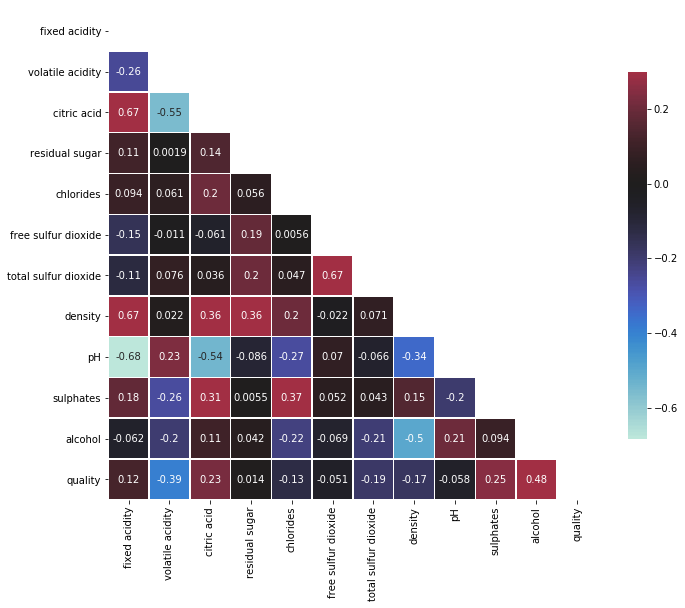

In [6]:
corr = Wine_data.corr()  # generate the cooreleation value between columns
mask = np.zeros_like(corr, dtype=np.bool) # creates matrice which contain the boolean value false
mask[np.triu_indices_from(mask)] = True  # set the upper triangle part of the triangle to true
plt.subplots(figsize=(11, 9)) # Set up the matplotlib figure
sns.heatmap(corr,annot=True, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

In [7]:
Wine_data[Wine_data.columns].corr()['quality']

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

In [8]:
#sSelecting the training columns 
Wine_column = ['quality','fixed acidity','citric acid','sulphates','alcohol','volatile acidity','total sulfur dioxide']
Wine_train_data = Wine_data[Wine_column]

### 3. Spliting the dataset into 80% Train set and 20% Test set.

In [9]:
def data_split(data, percentage, seed, index_reset=False):
    train = data.sample(frac=percentage/100, random_state=seed)
    tes = data.drop(train.index)
    if index_reset != False:
        train.reset_index(drop=True, inplace=True)
        tes.reset_index(drop=True,inplace=True)
    return train, tes

In [10]:
Wine_train , Wine_test = data_split(Wine_train_data, 80, 50, True)

In [11]:
#---------Wine---------------------------------
X_wine = Wine_train.drop('quality',axis=1).values
Y_wine = Wine_train['quality'].values 
Y_wine = Y_wine.reshape(-1,1)

X_wine_test = Wine_test.drop('quality',axis=1).values
Y_wine_test = Wine_test['quality'].values 
Y_wine_test = Y_wine_test.reshape(-1,1)

Note:
In regularisation, it is import to normalize the data set before passing the model. This avoid over/underpenalize a feature due its scale

In [12]:
#----Scaling functions ------------------------ 
def Stand_dev(M):
    "this return the standart deviation the column"
    return np.sqrt(sum((M-M.mean())**2)/len(M))

def scale(X):
    "REscaling the Training dataset, this return the normilize of the columns "
    for i in range(X.shape[1]):
        mean = np.mean(X[:,[i]])
        m = min(X[:,[i]])
        ma = max(X[:,[i]])
     
        X[:,[i]] = (X[:,[i]]-mean)/Stand_dev(X[:,[i]])
 
    
#---------end------------------------------------------


In [13]:
#applying the the normilize funciton to the dataset, Here `i will only scale the Xs 
to_scale = [X_wine,  X_wine_test]  # 
for i in to_scale:
    scale(i)

### Applying the model  

#### Regularize and non-regularize 

In [14]:
def minibatch(x_train, y_train, batchsize):
    "Yield minibacth with the given batchsizw"
    index = np.arange(0, len(y_train))   #a list of the dataset indexes 
    np.random.shuffle(index)
    batches = np.array_split(index, len(y_train)//batchsize) # spliting the indexes among the number of batches 
    for batche in batches:
        yield x_train[np.array(batche)], y_train[np.array(batche)] # yield the suffled data 

        
def L2reg(Theta):
    w = np.dot(Theta.T, Theta)
    #we set the offset to zero/not regularize, since it afecte only the height of the function 
    # and does not affect the complexity 
    w[0] = 0 
    return np.sum(w)


def RMSE(Y, Y_hat):
    return np.sqrt(sum((Y-Y_hat)**2)/len(Y))   

In [15]:

def predict(X, Theta):
    return np.dot(X, Theta)

def lin_func(X,Y,Theta,lam=0):
    M = len(Y)
     
    return np.sum((Y-predict(X,Theta))**2)*(1/(M)) + lam*L2reg(Theta)

def f_partial(X,Y,para,lam=0):
    
    M = len(Y)
    p = (-2/M)*np.dot(X.T,(Y-predict(X,para)))+2*lam*para
    return p


def bolddriver(x, y, btha,loss, grad, mu_old,lam ):
    mu = mu_old*1.1
    while loss(x,y,btha,lam) - loss(x,y,(btha - mu*grad),lam) < 0:
        mu *=0.5    
    return mu



def minimize_GD_bold(X_train, Y_train, X_test, Y_test, para_init,lr,\
                     epoch, batchsize ,e , lam, bold):
    t = 0  
    rmse_train = {}
    rmse_test  = {}
    to_plot    = {}
    for ep in range(epoch):
        
        
        for X, Y in minibatch(X_train, Y_train, batchsize):
            f_ini     = lin_func(X,Y,para_init,lam)
            grad      = f_partial(X,Y, para_init, lam)
            if bold:
                lr        = bolddriver(X,Y,para_init,lin_func, grad, lr, lam)
            para_nex  = para_init - lr*grad
            f_nex     = lin_func(X,Y, para_nex) 
            
            f_nex     = lin_func(X,Y, para_nex)
            to_plot[t]= abs(f_ini - f_nex)
            rmse_test[t] = RMSE(Y_test,predict(X_test, para_init) )
            rmse_train[t]= RMSE(Y_train,predict(X_train, para_init) )
            para_init = para_nex
            
            t        += 1
        
        
    return para_nex, rmse_test, rmse_train, rmse_test[t-1][-1]

def learn_ridgereg_GD_bold(X, Y, X_tes, Y_tes ,lr, epoch=1000, \
                           batchsize=50,e=10**-6, lam=1, bold=False):
    
    "Fit the model and return Theta values"
    
    try:
        Y.shape[1]
    except IndexError :
        Y = Y.reshape(-1,1)
     
    ones     = np.ones(X.shape[0]).reshape(-1,1)
    X        = np.hstack([ones, X])
    ones_tes = np.ones(X_tes.shape[0]).reshape(-1,1)
    X_tes    = np.hstack([ones_tes, X_tes])
    Theta_0  = np.ones(X.shape[1]).reshape(-1,1)  # the dimention of theta = number of features
    
    return minimize_GD_bold(X,Y , X_tes, Y_tes,Theta_0,lr,epoch, batchsize,e,lam,bold )




***Ploting regularize vs non regularise***

In [19]:
epoch = 1
minbatchsize = 1 
lern_rat = 0.01 
lamb = 0.1
lamb1 = 0
para_nex, rmse_test, rmse_train, to_plot = learn_ridgereg_GD_bold(X_wine, Y_wine, X_wine_test, Y_wine_test ,lr=lern_rat, \
                             epoch=epoch, batchsize=minbatchsize,\
                             e=10**-6, lam=lamb, bold=False)
para_nex1, rmse_test1, rmse_train1, to_plot1 = learn_ridgereg_GD_bold(X_wine, Y_wine, X_wine_test, Y_wine_test ,lr=lern_rat, \
                             epoch=epoch, batchsize=minbatchsize,\
                             e=10**-6, lam=lamb1, bold=False)

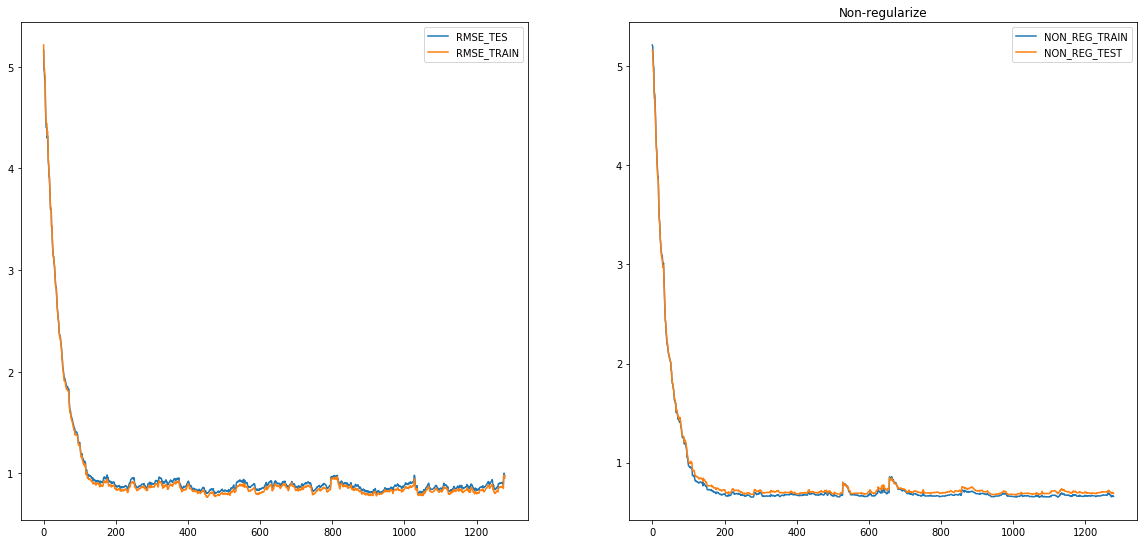

In [20]:
# plotint the result of the RMSE 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,9.15))
 
lists =  rmse_test.items() 
x, y = zip(*lists)
lists1 =  rmse_train.items() 
x1, y1 = zip(*lists1)
lists3 =  rmse_train1.items() 
x3, y3 = zip(*lists3)
lists4 =  rmse_test1.items() 
x4, y4 = zip(*lists4)
#lists2 =  to_plot.items() 
#x2, y2 = zip(*lists2)
ax[0].plot(x, y,label= 'RMSE_TES')
ax[0].plot(x1, y1,label= 'RMSE_TRAIN')
ax[1].plot(x3, y3,label= 'NON_REG_TRAIN')
ax[1].plot(x4, y4,label= 'NON_REG_TEST')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
#ax[1].plot(x2, y2)
ax[1].title.set_text('Regularize')
ax[1].title.set_text('Non-regularize')


***Choosing deffferent value of alpha and lambda using fix learning rate***

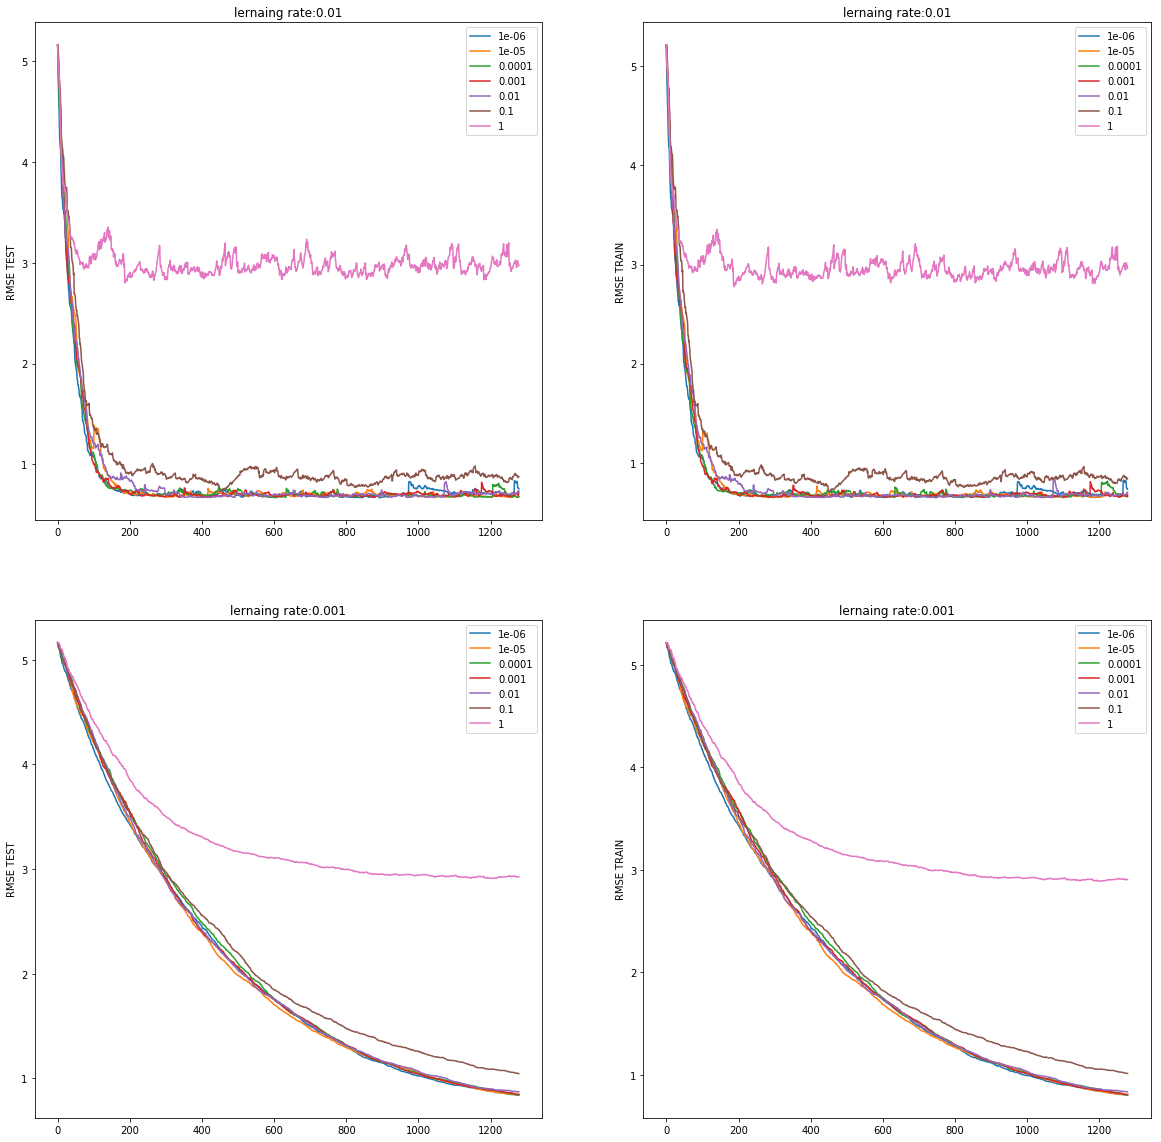

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20.15))
lern_ra  = [10**-x for x in range(2,4)]       # i choose 5 step size 
minbatchsize = 1 
epoch = 1
lamb = [10**x for x in range(-6,1)]
t = 2
for lr in  lern_ra:
    for num, el in enumerate(lamb):
        _, rmse_test, \
        rmse_train, \
        to_plot = \
        learn_ridgereg_GD_bold(X_wine, \
                               Y_wine, X_wine_test, \
                               Y_wine_test ,lr=lr, epoch=epoch, \
                               batchsize=minbatchsize,e=10**-6, \
                               lam=el, bold=False)
        
        
        lists =  rmse_test.items() 
        lists1 =  rmse_train.items() 
        x, y = zip(*lists)
        x1, y1 = zip(*lists1)
        ax[2-t][0].plot(x, y, label=el)
        ax[2-t][0].title.set_text('lernaing rate:'+str(lr))
        ax[2-t][1].plot(x1, y1, label=el)
        ax[2-t][1].title.set_text('lernaing rate:'+str(lr))
        ax[2-t][0].legend(loc='best')
        ax[2-t][1].legend(loc='best')
        
        ax[2-t][1].set_ylabel("RMSE TRAIN")
        ax[2-t][0].set_ylabel("RMSE TEST")
    
    t-=1



***Choosing deffferent value of alpha and lambda using boldriver stesize controller ***

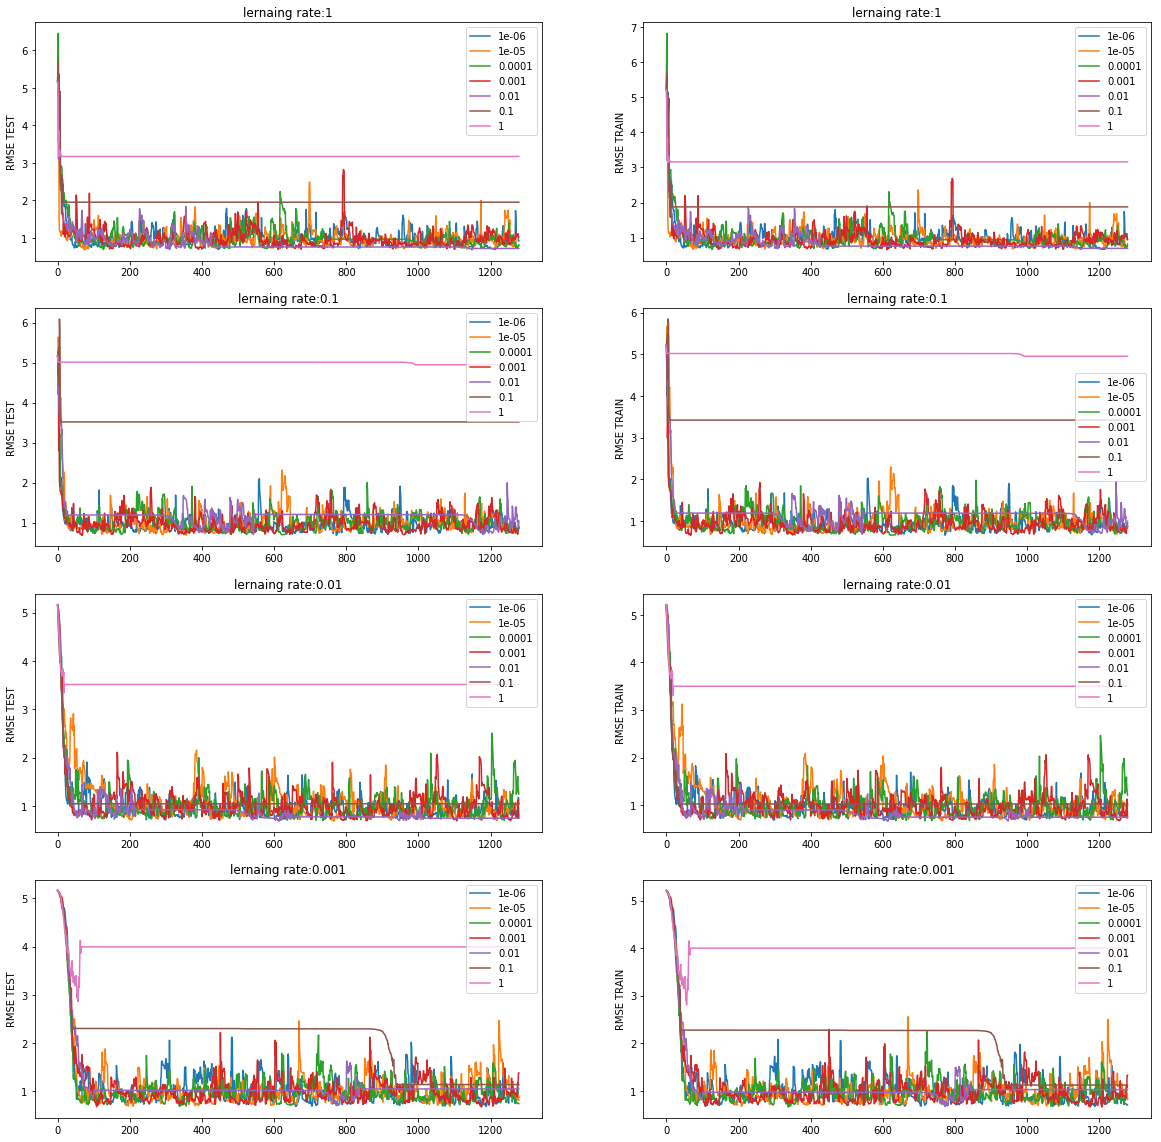

<Figure size 432x288 with 0 Axes>

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20,20.15))
lern_ra  = [10**-x for x in range(4)]       # i choose 5 step size 
fig = plt.figure()
minbatchsize = 1 
epoch = 1
lamb = [10**x for x in range(-6,1)]
t = 4
for lr in  lern_ra:
    for num, el in enumerate(lamb):
        _, rmse_test, \
        rmse_train, \
        to_plot = \
        learn_ridgereg_GD_bold(X_wine, \
                               Y_wine, X_wine_test, \
                               Y_wine_test ,lr=lr, epoch=epoch, \
                               batchsize=minbatchsize,e=10**-6, \
                               lam=el, bold=True)
        
        
        lists =  rmse_test.items() 
        lists1 =  rmse_train.items() 
        x, y = zip(*lists)
        x1, y1 = zip(*lists1)
        ax[4-t][0].plot(x, y, label=el)
        ax[4-t][0].title.set_text('lernaing rate:'+str(lr))
        ax[4-t][1].plot(x1, y1, label=el)
        ax[4-t][1].title.set_text('lernaing rate:'+str(lr))
        ax[4-t][0].legend(loc='best')
        ax[4-t][1].legend(loc='best')
        
        ax[4-t][1].set_ylabel("RMSE TRAIN")
        ax[4-t][0].set_ylabel("RMSE TEST")
    
    t-=1
 


## Hyperparameter tuning and Cross validation

In [20]:
# I define K fold funciton 

def kfolder(x, y, model=None, modelparameters=None, alpha=0.1, lam=0,fold=10):
    """Yield minibacth with the given batchsizw, notice that   RMSE_TRAIN, RMSE_TEST
    are dictionairy insid of dictionary"""
    
    index = np.arange(0, len(y))   #a list of the dataset indexes 
    np.random.shuffle(index)
    folds = np.array_split(index, fold) # spliting the indexes among the number of fold
    
    RMSE_TEST = {}
    RMSE_TRAIN = {}
    LAS_RMSE_TEST = 0
    for f in range(fold):
        validation = folds[f]
        training_set = np.setdiff1d(index , validation)
        X_train, Y_train = x[np.array(training_set)], y[np.array(training_set)] 
        X_test, Y_test = x[np.array(validation)], y[np.array(validation)]
        # now training the nfold 
        _, trainRMSE, testRMSE, RMSE_tes_last = model( X_train, Y_train,X_test, Y_test,**modelParameters, lr=alpha, lam=lam)
        RMSE_TEST[f]     = testRMSE
        RMSE_TRAIN[f]    = trainRMSE
        LAS_RMSE_TEST   += RMSE_tes_last

    return   RMSE_TRAIN, RMSE_TEST, LAS_RMSE_TEST
    

In [21]:
from itertools import product 

# product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
# product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
# I wil use that to combine all possible paire wise combination 

def Gride_search(x_train, y_train, x_test, y_test, model, modelparameter, hyperParameters, 
               num_fold = 1 ):
    #inittialise the best parameters
    bes_score = None
    best_parameter = {}
     
    # now we generate parameters for the gride 
    
    hyperparam = set(product(*hyperParameters.values())) # putting all combination in the set as to enforce the uniquness
    hyperParameterKeys = hyperParameters.keys()
    
    t = 0
    fig, axs = plt.subplots(nrows=len(hyperparam), ncols=2, figsize=(20,10*len(hyperparam))) 
    
    # setting up for 3D ploting                            
    fig1 = plt.figure(figsize=(20,10))
    axd = fig1.add_subplot(111, projection='3d')


    """Perform grid search with cross validation"""
    
    for alpha, lam in hyperparam:
        RMSE_TRAIN, RMSE_TEST, LAS_RMSE_TEST = kfolder(x_train, y_train, model, modelparameter, alpha, lam, num_fold )  

        # storing the best hyperparameters
        avg_best =  LAS_RMSE_TEST/num_fold     # avereging the RMSE on the test 
        if bes_score == None or avg_best < bes_score:
            bes_score = avg_best
            best_parameter['alpha'] = alpha 
            best_parameter['lam'] = lam 

        for k in range(num_fold):
            lists =  RMSE_TEST[k].items() 
            lists1 =  RMSE_TRAIN[k].items() 
            x, y = zip(*lists)
            x1, y1 = zip(*lists1)
            axs[t][0].plot(x,y, label = "Fold-" + str(k))
            axs[t][1].plot(x1,y1, label = "Fold-" + str(k))
            axs[t][0].legend()
            axs[t][1].legend()
            axs[t][0].grid()
            axs[t][1].grid()
            axs[t][0].set_title("Train-α="+ str(alpha)+'λ='+str(lam))
            axs[t][1].set_title("Validation" + str(alpha)+'λ='+str(lam))


        t += 1
            #Keep tracking of mean performance (i.e. RMSE value) across k−folds for each set of hyperparameters.
                           
        axd.scatter(alpha, lam, avg_best, marker = '^', label = str(alpha)+'λ='+str(lam))

        axd.set_xlabel('alpha')
        axd.set_ylabel('lambda')
        axd.set_zlabel('fold_RMSE')
        axd.legend()
        axd.view_init(60, 35)

    #lastly run the the model with the best 
    lr = best_parameter['alpha']
    lam = best_parameter['lam'] 
    plotHeight = 10
    plotWidth = 20
    fig2, ax = plt.subplots(1, 2, figsize = (plotWidth, plotHeight)) 
    _, RMSE_TRAIN, RMSE_TEST, LAS_RMSE_TEST = model(x_train, y_train, x_test, y_test, **modelparameter, lr= lr, lam=lam) 
                   
    lists =  RMSE_TEST.items() 
    lists1 =  RMSE_TRAIN.items() 
    x, y = zip(*lists)
    x1, y1 = zip(*lists1)
    ax[0].plot(x,y, label = "RMSE TES FOR" + str(alpha)+'λ='+str(lam))
    ax[0].legend()
    ax[0].grid()
    ax[1].plot(x1,y1, label = "RMSE TRAIN FOR" + str(alpha)+'λ='+str(lam))
    ax[1].legend()
    ax[1].grid()
    plt.suptitle("Best model")

    return bes_score, best_parameter

#### gride search with step lenght controller( bolddriver)

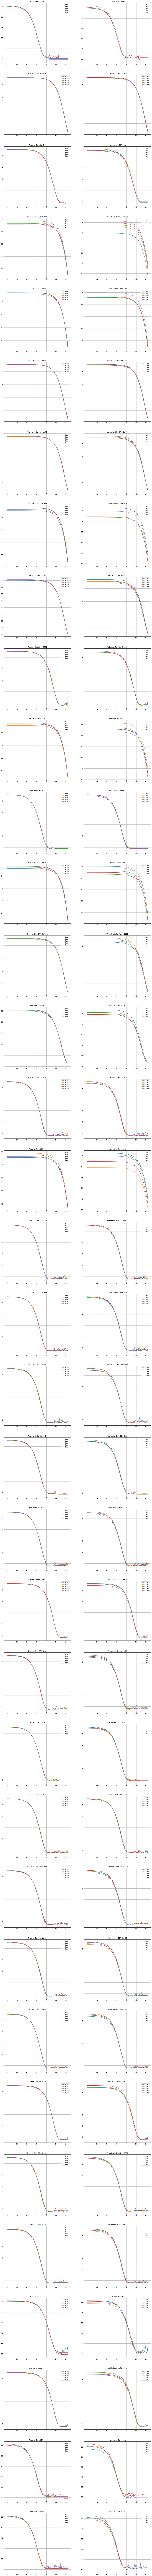

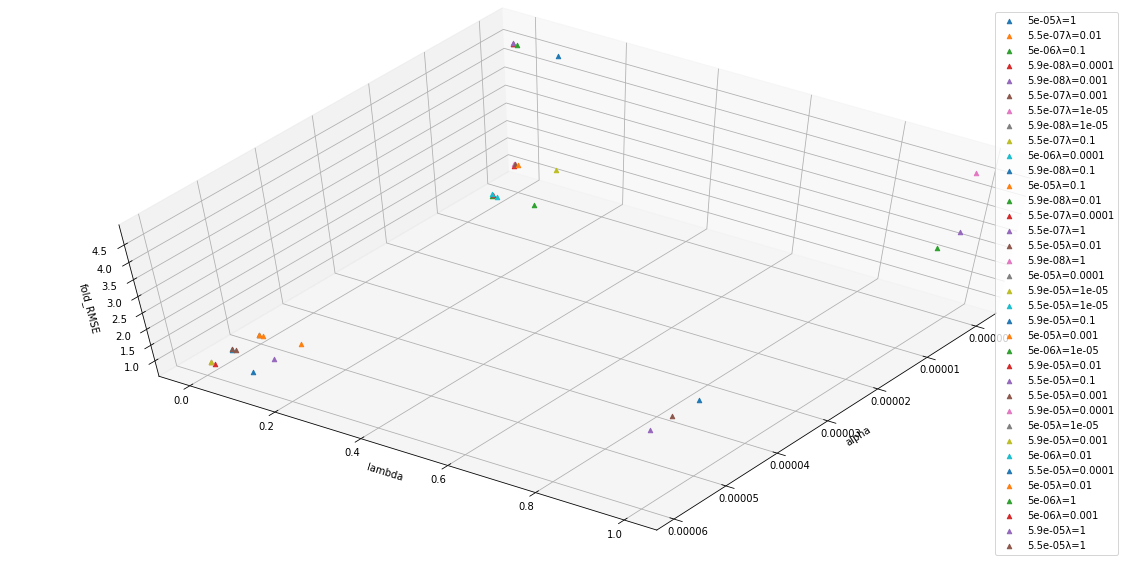

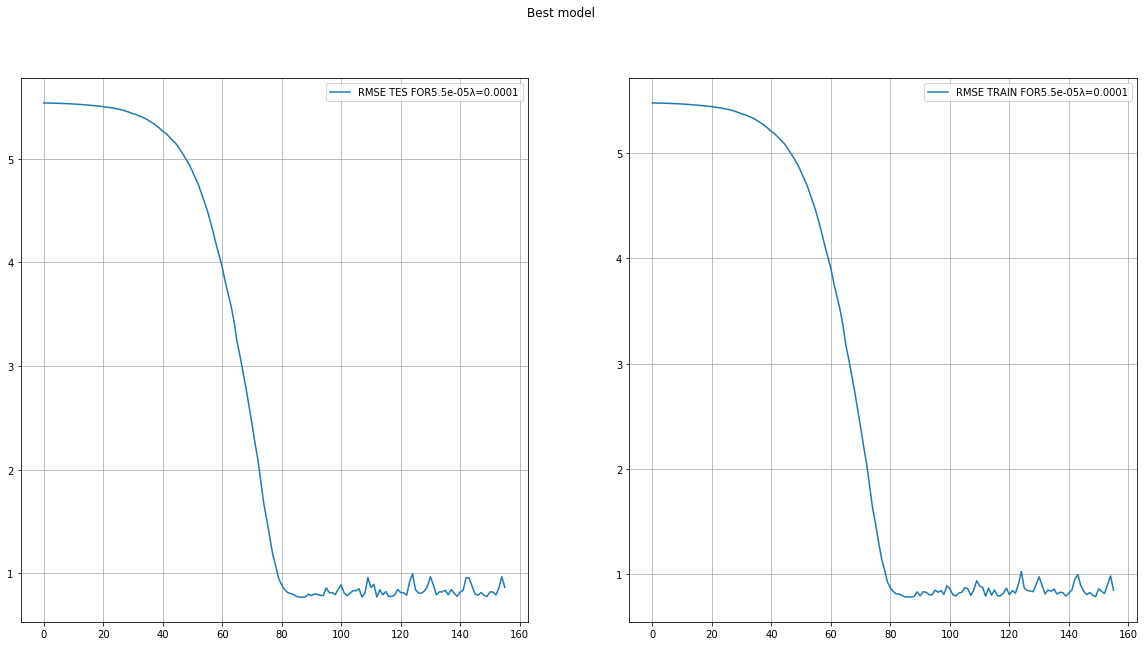

In [22]:
lamb = [10**x for x in range(-5,1)]
hyperparameters = {
    "alpha":[5.0e-5, 5.5e-5, 5.9e-5, 5.0e-6, 5.5e-7, 5.9e-8],
    "lam": lamb
}


modelParameters = {
    "epoch":2, 
    "batchsize":50, 
    "bold": True}
 
    
model, hyperParams = Gride_search(X_wine, Y_wine, X_wine_test,Y_wine_test,learn_ridgereg_GD_bold, modelParameters,\
                                  hyperparameters, num_fold=5)

 

#### gride search with fix step lenght 

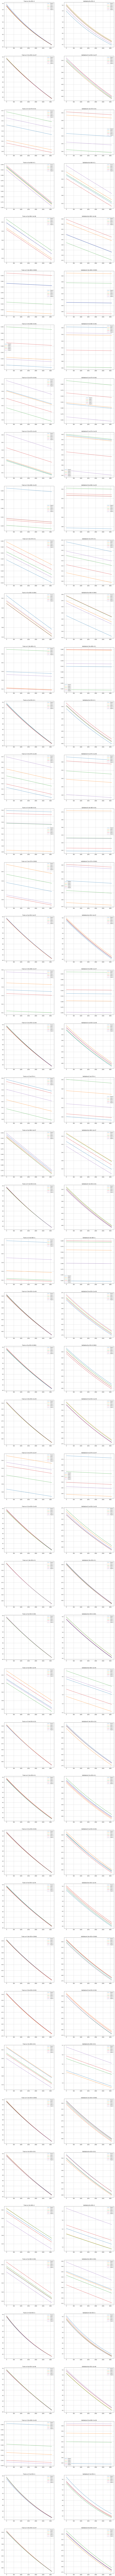

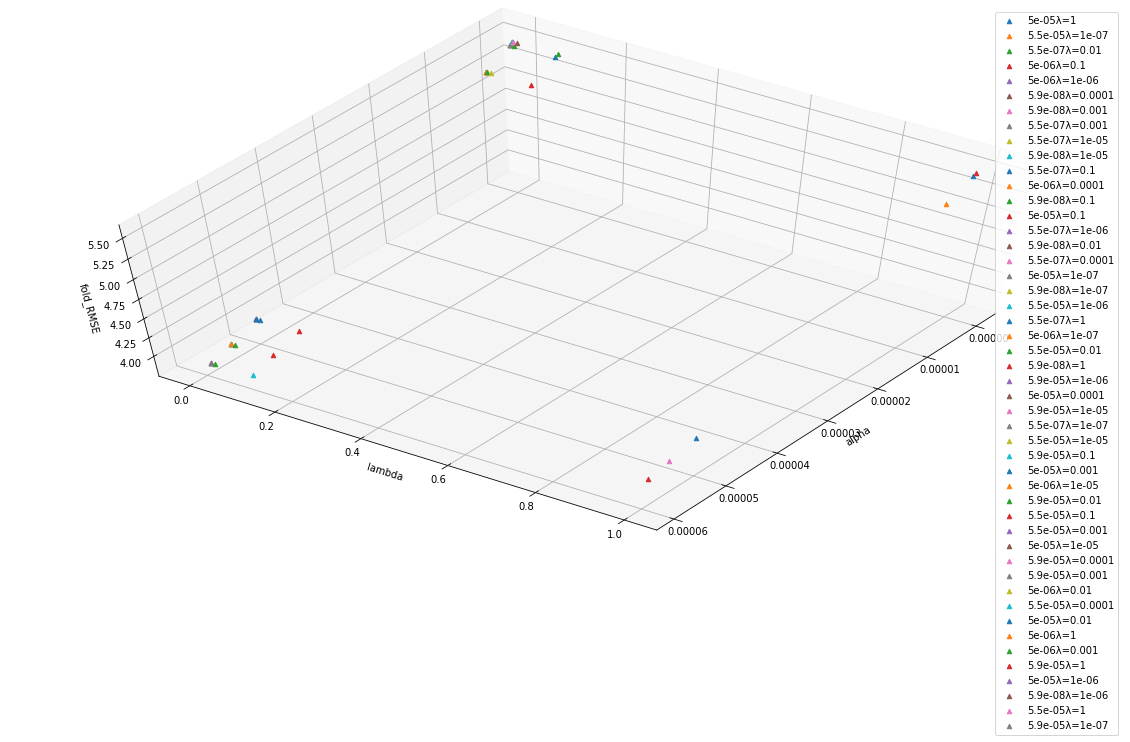

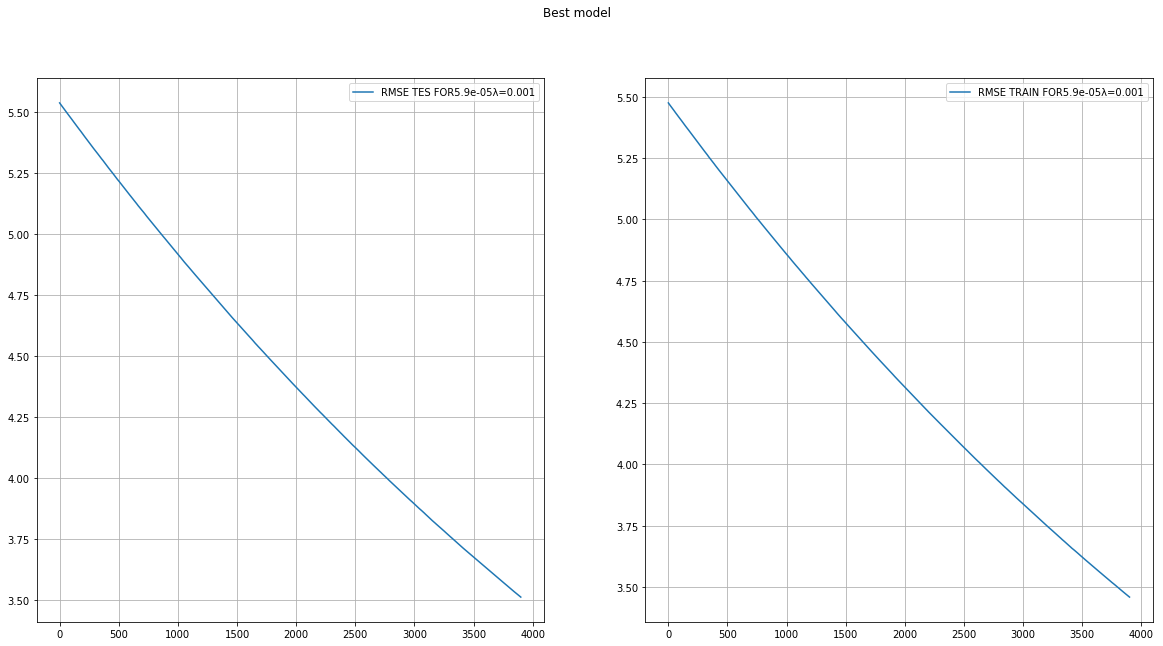

In [23]:
lamb = [10**x for x in range(-7,1)]
hyperparameters = {
    "alpha":[5.0e-5, 5.5e-5, 5.9e-5, 5.0e-6, 5.5e-7, 5.9e-8],
    "lam": lamb
}


modelParameters = {
    "epoch":50, 
    "batchsize":50, 
    "bold": False}
 
    
model, hyperParams = Gride_search(X_wine, Y_wine, X_wine_test,Y_wine_test,learn_ridgereg_GD_bold, modelParameters,\
                                  hyperparameters, num_fold=5)

 

In [24]:
X_wine


array([[ 1.19251065,  1.83761208,  0.51317071,  0.74780098, -1.11820968,
        -0.73623919],
       [-1.22545965, -1.38310546,  1.13032666, -0.9488736 ,  0.28785247,
        -0.85779927],
       [ 0.38652055,  0.71291706, -0.3508476 ,  1.69039798, -0.72451228,
        -0.18921885],
       ...,
       [ 0.32894983,  0.91740706,  0.6366019 ,  1.40761888, -2.2993019 ,
        -0.76662921],
       [-0.36189883, -0.46290045, -0.3508476 , -0.19479601,  0.45657993,
        -0.79701923],
       [-1.34060109, -1.12749296,  0.76003309,  0.18224279,  0.62530739,
        -0.88818929]])